In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10683.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10736.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10489.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10512.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10975.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10064.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10281.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10384.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10986.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10870.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10786.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10268.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10760.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10759.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_11008

In [11]:
#Import necessary libraries
"""
We begin by importing essential libraries for:
- Data processing (NumPy, Pandas)
- Image handling (OpenCV, Matplotlib)
- Deep learning (TensorFlow/Keras)
- Progress monitoring (tqdm)
- System operations (os)
"""
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Suppress warnings for clarity
import warnings
warnings.filterwarnings('ignore')

In [12]:
#Verify TensorFlow installation and GPU availability
print("TensorFlow Version:", tf.__version__)
print("Is GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.17.1
Is GPU Available: []


In [14]:
#Define dataset paths
"""
Specify the paths to the training and testing datasets.
"""
train_path = "/kaggle/input/waste-classification-data/DATASET/TRAIN"
test_path = "/kaggle/input/waste-classification-data/DATASET/TEST"


In [15]:
#Visualization
from cv2 import cvtColor
x_data = []
y_data = []
for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])
data = pd.DataFrame({'image': x_data, 'label': y_data})


100%|██████████| 12565/12565 [01:22<00:00, 152.02it/s]


In [16]:
data.shape

(22564, 2)

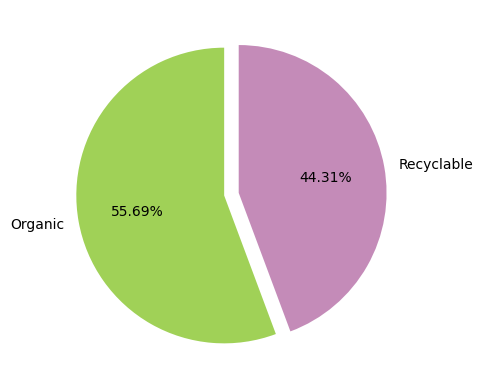

In [18]:
colors = ['#a0d157', '#c48bb8']
plt.pie(data.label.value_counts(), labels=['Organic', 'Recyclable'], autopct='%0.2f%%',
        colors=colors, startangle=90, explode=[0.05, 0.05])
plt.show()

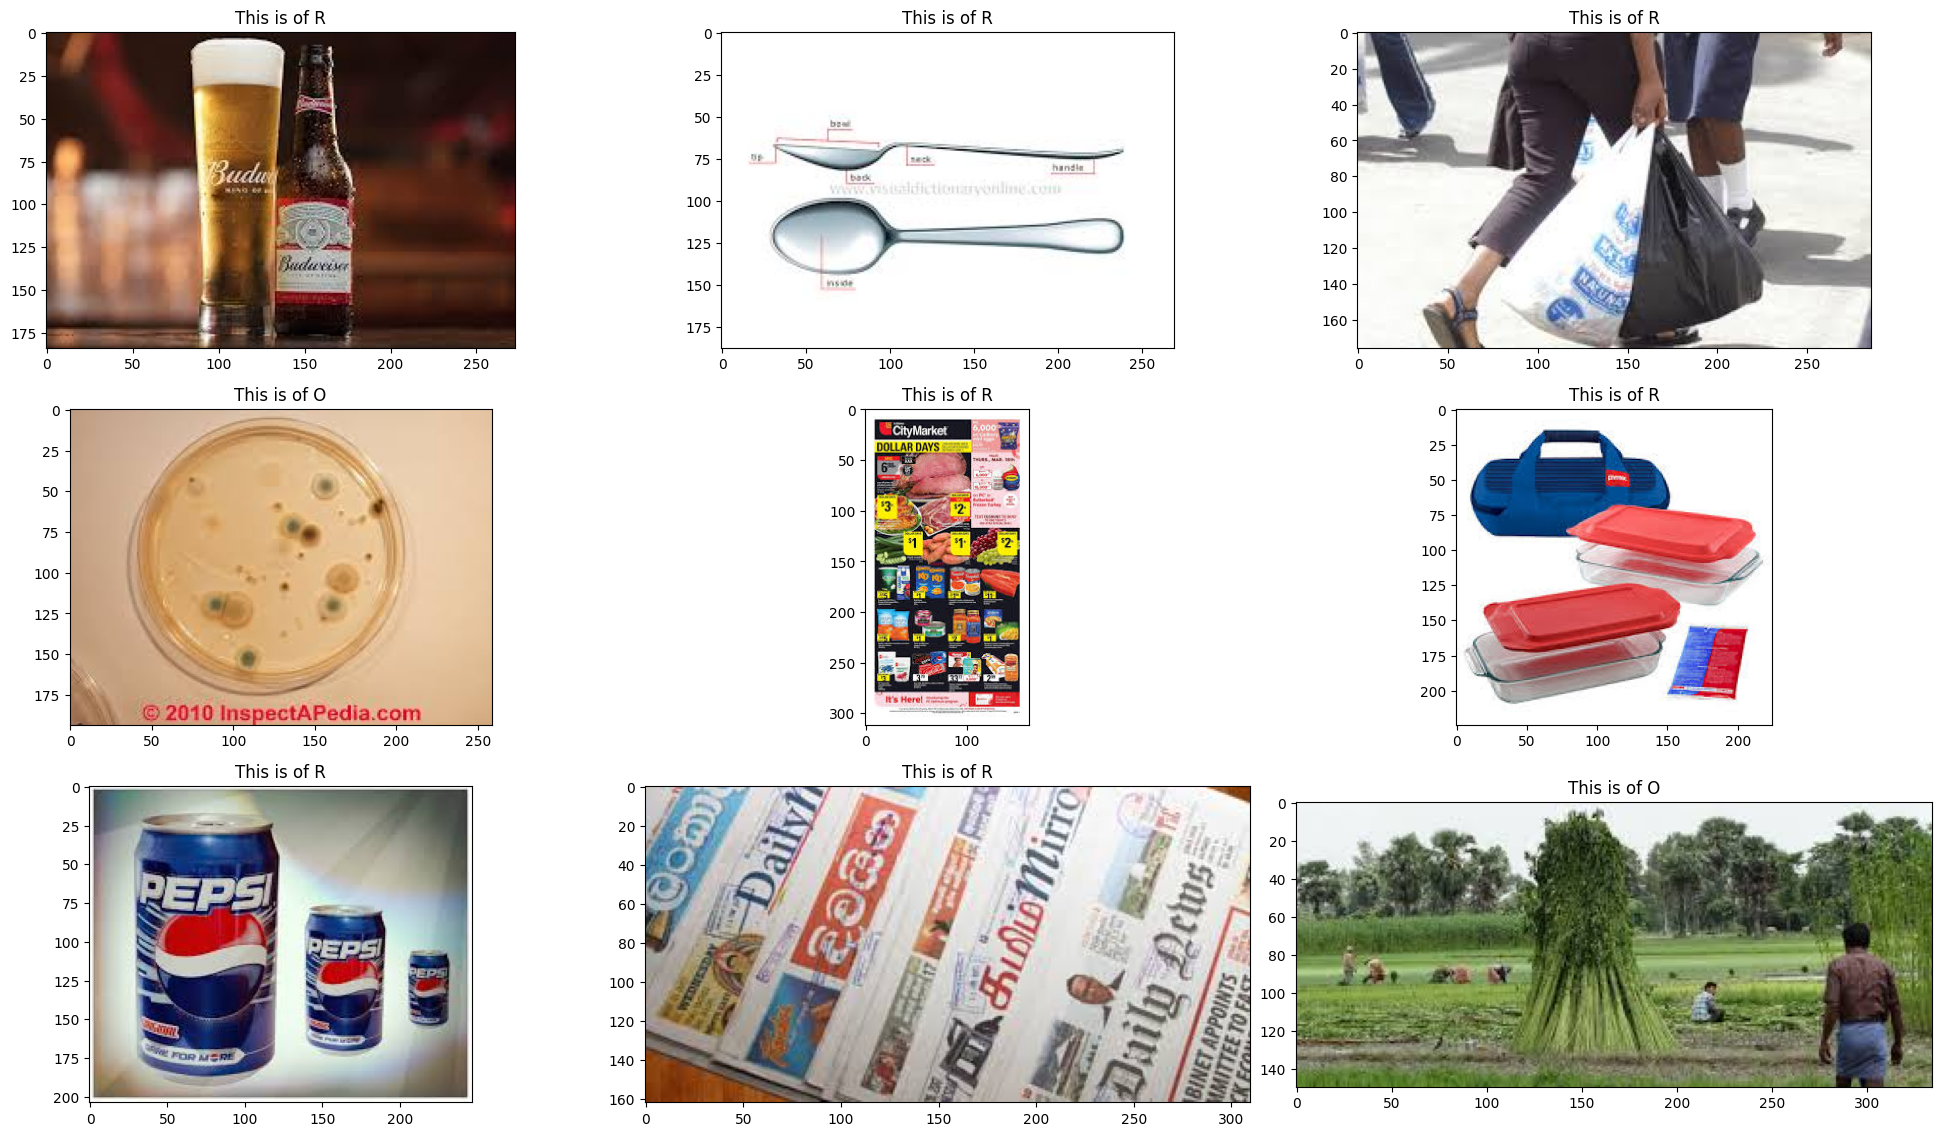

In [19]:
plt.figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(4, 3,(i%12)+1)
    index = np.random.randint(15000)
    plt.title('This is of {0}'.format(data.label[index]))
    plt.imshow(data.image[index])
    plt.tight_layout()

In [20]:
#Data Augmentation for better generalization
"""
We use `ImageDataGenerator` to apply transformations such as:
- Rotation, width/height shift, shear, zoom, and flipping
- Rescaling pixel values to [0,1]
- Splitting training data into training (80%) and validation (20%)
"""
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


In [21]:
#Load training and validation data
"""
Generate training and validation datasets using augmentation.
Target size: 150x150 pixels, batch size: 32, class mode: categorical.
"""
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


In [22]:
#building a CNN model


def build_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        MaxPooling2D(2,2),
        BatchNormalization(),


        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),


        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),


        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])
    return model


In [23]:
# Compile the CNN model


model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [24]:
# Display Model Summary


model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,586 (72.61 MB)

 Trainable params: 19,035,138 (72.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
#Implement early stopping and checkpointing


callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)  # Updated file format
]


In [29]:
# Train the CNN model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3,
    callbacks=callbacks
)


Epoch 1/3
565/565 ━━━━━━━━━━━━━━━━━━━━ 704s 1s/step - accuracy: 0.8691 - loss: 0.3185 - val_accuracy: 0.8613 - val_loss: 0.3287
Epoch 2/3
565/565 ━━━━━━━━━━━━━━━━━━━━ 705s 1s/step - accuracy: 0.8697 - loss: 0.3231 - val_accuracy: 0.8424 - val_loss: 0.3452
Epoch 3/3
565/565 ━━━━━━━━━━━━━━━━━━━━ 701s 1s/step - accuracy: 0.8692 - loss: 0.3155 - val_accuracy: 0.8652 - val_loss: 0.3168


In [30]:
 #Save the trained model
model.save("Waste-Classification-CNN-Model.h5")

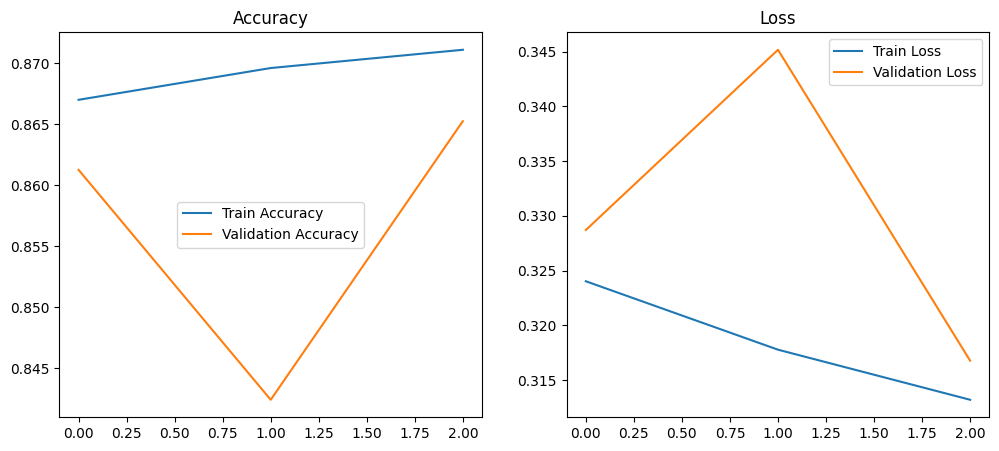

In [31]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')


plt.show()


In [32]:
# Load the Trained Model


from tensorflow.keras.models import load_model


# Load the best saved model
model = load_model("Waste-Classification-CNN-Model.h5")


# Display the model architecture again to verify loading
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,588 (72.62 MB)

 Trainable params: 19,035,138 (72.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

In [33]:
#Prepare Test Data


test_path = "/kaggle/input/waste-classification-data/DATASET/TEST"


# Rescale test images to match training data
test_datagen = ImageDataGenerator(rescale=1./255)


# Load test dataset with similar preprocessing
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle so that labels remain aligned
)


Found 2513 images belonging to 2 classes.


In [34]:
# Evaluate model accuracy on test set
test_loss, test_accuracy = model.evaluate(test_generator)


print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 285ms/step - accuracy: 0.9282 - loss: 0.1989
Test Accuracy: 90.09%
Test Loss: 0.2918


In [35]:
# Make Predictions on Test Images


import numpy as np


# Get predictions (probabilities)
predictions = model.predict(test_generator)


# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)


# Get actual class labels from test generator
actual_classes = test_generator.classes


# Get class labels (to map indices back to names)
class_labels = list(test_generator.class_indices.keys())


# Print sample predictions
print("Predicted Classes:", [class_labels[i] for i in predicted_classes[:10]])
print("Actual Classes:", [class_labels[i] for i in actual_classes[:10]])


79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step
Predicted Classes: ['O', 'O', 'O', 'O', 'R', 'O', 'O', 'O', 'O', 'O']
Actual Classes: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


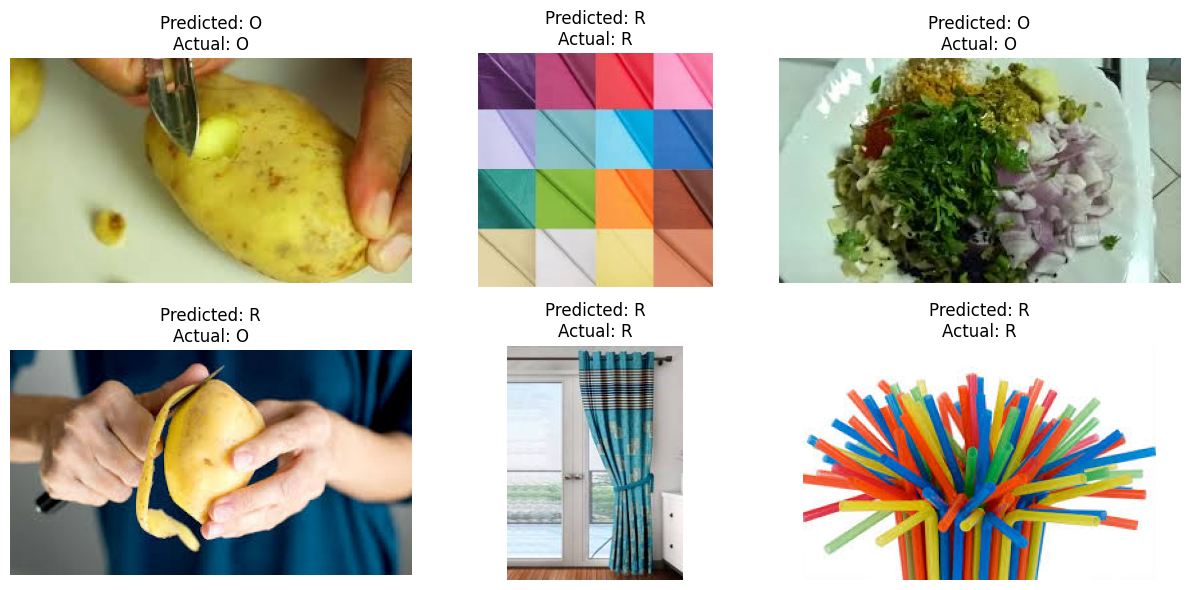

In [41]:
"""
#Visualize Some Test Images with Predictions
We randomly select some test images and display them with predicted labels.
"""
import matplotlib.pyplot as plt


# Get file names for test images
test_image_paths = test_generator.filepaths


# Select random indices
random_indices = np.random.choice(len(test_image_paths), 6, replace=False)


plt.figure(figsize=(12, 6))


for i, idx in enumerate(random_indices):
    img = cv2.imread(test_image_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display


    # Get predicted label
    predicted_label = class_labels[predicted_classes[idx]]
    actual_label = class_labels[actual_classes[idx]]


    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}", fontsize=12)


plt.tight_layout()
plt.show()

Classification Report:

              precision    recall  f1-score   support

           O       0.89      0.94      0.91      1401
           R       0.92      0.86      0.88      1112

    accuracy                           0.90      2513
   macro avg       0.90      0.90      0.90      2513
weighted avg       0.90      0.90      0.90      2513



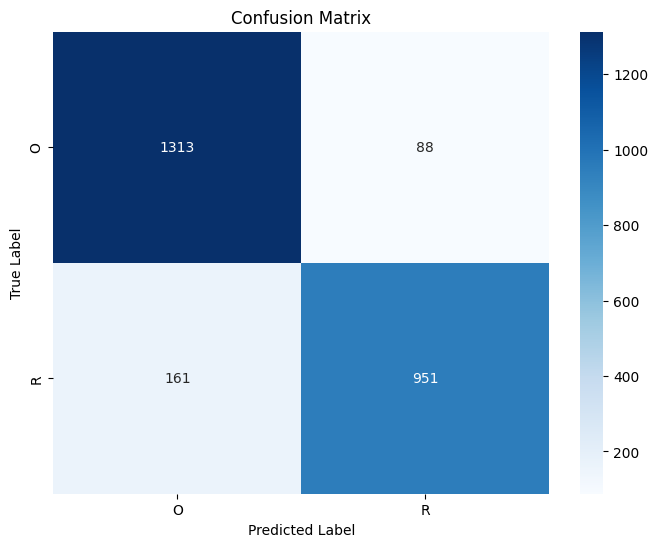

In [42]:
# Generate Classification Report and Confusion Matrix


from sklearn.metrics import classification_report, confusion_matrix


# Print classification report
print("Classification Report:\n")
print(classification_report(actual_classes, predicted_classes, target_names=class_labels))


# Generate and plot confusion matrix
import seaborn as sns


cm = confusion_matrix(actual_classes, predicted_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()